## Name - Sandipan Majhi (24AI60R21), Aayush Sugandh (24AI60R04)
## GML Assignment-4

In [1]:
!pip install -q pykeen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from pykeen.datasets import Nations, Kinships

INFO:pykeen.utils:Using opt_einsum


## Part 1 : Train TransE and TransR on Nations and Kinships dataset

In [3]:
def extract_triples(triple):
  return triple[0], triple[1], triple[2]


In [4]:
class TransE(nn.Module):
  def __init__(self, num_entities, num_relations, embedding_dim, margin, norm):
    super(TransE, self).__init__()

    self.embeddings = nn.Embedding(num_entities, embedding_dim)
    self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)
    self.margin = margin
    self.norm = norm

    nn.init.xavier_uniform_(self.embeddings.weight.data)
    nn.init.xavier_uniform_(self.relation_embeddings.weight.data)

  def forward(self, head, relation, tail):
    head_embedding = self.embeddings(head)
    relation_embedding = self.relation_embeddings(relation)
    tail_embedding = self.embeddings(tail)

    head_embedding = F.normalize(head_embedding, p=self.norm, dim=-1)
    relation_embedding = F.normalize(relation_embedding, p=self.norm, dim=-1)
    tail_embedding = F.normalize(tail_embedding, p=self.norm, dim=-1)

    return head_embedding, relation_embedding, tail_embedding

  def get_score(self, head_embedding, relation_embedding, tail_embedding):
    return torch.norm(head_embedding + relation_embedding - tail_embedding, p=self.norm, dim=-1)

  def get_embeddings(self, entity_id):
    return self.embeddings[entity_id]

In [5]:
class TransR(nn.Module):
  def __init__(self, num_entities, num_relations, embedding_dim, margin, norm):
    super(TransR, self).__init__()
    self.embedding_dim = embedding_dim

    self.embeddings = nn.Embedding(num_entities, embedding_dim)
    self.relation_embeddings = nn.Embedding(num_relations, embedding_dim)
    self.margin = margin
    self.norm = norm

    self.relation_proj = nn.Embedding(num_relations, embedding_dim * embedding_dim)

    nn.init.xavier_uniform_(self.relation_proj.weight.data)
    nn.init.xavier_uniform_(self.embeddings.weight.data)
    nn.init.xavier_uniform_(self.relation_embeddings.weight.data)

  def forward(self, head, relation, tail):
    head_embedding = self.embeddings(head)
    relation_embedding = self.relation_embeddings(relation)
    tail_embedding = self.embeddings(tail)

    rel_proj = self.relation_proj(relation).view(-1, self.embedding_dim, self.embedding_dim)

    head_embedding = torch.bmm(self.relation_proj(relation).view(-1, self.embedding_dim, self.embedding_dim), head_embedding.unsqueeze(dim = 2))
    tail_embedding = torch.bmm(self.relation_proj(relation).view(-1, self.embedding_dim, self.embedding_dim), tail_embedding.unsqueeze(dim = 2))

    head_embedding = head_embedding.squeeze(dim = 2)
    tail_embedding = tail_embedding.squeeze(dim = 2)

    head_embedding = F.normalize(head_embedding, p=self.norm, dim=-1)
    relation_embedding = F.normalize(relation_embedding, p=self.norm, dim=-1)
    tail_embedding = F.normalize(tail_embedding, p=self.norm, dim=-1)

    return head_embedding, relation_embedding, tail_embedding

  def get_score(self, head_embedding, relation_embedding, tail_embedding):
    return torch.norm(head_embedding + relation_embedding - tail_embedding, p=self.norm, dim=-1)

  def get_embeddings(self, entity_id):
    return self.embeddings[entity_id]

In [6]:
def get_probabilities(triples):
  relations_probs = {}
  relations_head_count = {}
  relations_tail_count = {}
  for triple in triples:
    head, relation, tail = extract_triples(triple)
    if relation not in relations_head_count:
      relations_head_count[relation] = []

    if relation not in relations_tail_count:
      relations_tail_count[relation] = []

    relations_head_count[relation].append(head)
    relations_tail_count[relation].append(tail)

  for k,v in relations_head_count.items():
    if k not in relations_probs:
      relations_probs[k] = {
          "avg_head_per_tail": 0,
          "avg_tail_per_head": 0
      }

    hpt = len(set(v)) / len(set(relations_tail_count[k]))
    tph = len(set(relations_tail_count[k])) / len(set(v))

    relations_probs[k]["avg_head_per_tail"] = hpt / (hpt + tph)
    relations_probs[k]["avg_tail_per_head"] = tph / (hpt + tph)

  return relations_probs, relations_head_count, relations_tail_count

def bernoulli_negative_sample(triples, num_entities, num_samples = 1):
  """
    We will sample one negative sample for one true sample
  """
  probs = get_probabilities(triples)[0]
  triples_with_negatives = []

  for triple in triples:
    head, relation, tail = extract_triples(triple)

    for _ in range(num_samples):

      if np.random.randint(1, 11) <= int(10 * probs[relation]["avg_head_per_tail"]):
        neg_head = np.random.randint(0, num_entities)
        negative_triple = [neg_head, relation, tail]

        while negative_triple in triples_with_negatives or negative_triple in triples:
          neg_head = np.random.randint(0, num_entities)
          negative_triple = [neg_head, relation, tail]


        triples_with_negatives.append((triple, negative_triple))

      else :
        neg_tail = np.random.randint(0, num_entities)
        negative_triple = [head, relation, neg_tail]

        while negative_triple in triples_with_negatives or negative_triple in triples:
          neg_tail = np.random.randint(0, num_entities)
          negative_triple = [head, relation, neg_tail]

        triples_with_negatives.append((triple, negative_triple))

  return triples_with_negatives

In [7]:
dataset = Nations()
train_triples = dataset.training.mapped_triples.tolist()
test_triples = dataset.testing.mapped_triples.tolist()
num_entities = dataset.num_entities
num_relations = dataset.num_relations

train_triples = bernoulli_negative_sample(train_triples, num_entities)
# test_triples = bernoulli_negative_sample(test_triples, num_entities)

train_triples = torch.LongTensor(train_triples)
test_triples = torch.LongTensor(test_triples)

train_triples = torch.utils.data.TensorDataset(train_triples)
test_triples = torch.utils.data.TensorDataset(test_triples)

batch_size = 128

nations_traindata = torch.utils.data.DataLoader(train_triples, batch_size=batch_size, shuffle=True)
nations_testdata = torch.utils.data.DataLoader(test_triples, batch_size=batch_size, shuffle=False)

In [8]:
kdataset = Kinships()
ktrain_triples = kdataset.training.mapped_triples.tolist()
ktest_triples = kdataset.testing.mapped_triples.tolist()
knum_entities = kdataset.num_entities
knum_relations = kdataset.num_relations

ktrain_triples = bernoulli_negative_sample(ktrain_triples, knum_entities, num_samples = 5)
# ktest_triples = bernoulli_negative_sample(ktest_triples, knum_entities)

ktrain_triples = torch.LongTensor(ktrain_triples)
ktest_triples = torch.LongTensor(ktest_triples)

batch_size = 512

kinship_traindata = torch.utils.data.DataLoader(ktrain_triples, batch_size=batch_size, shuffle=True)
kinship_testdata = torch.utils.data.DataLoader(ktest_triples, batch_size = batch_size, shuffle = False)

In [9]:
def loss_fn(pos_score, neg_score, margin):
  return torch.mean(torch.relu(pos_score - neg_score + margin))

In [10]:
def train_Nations(model, optimizer, train_triples,
                 batch_size, num_epochs, device):

  training_history = {
      "loss": [],
      "best_model" : None
  }

  for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in train_triples:
      optimizer.zero_grad()
      pos_sample = batch[0][:,0].to(device)
      neg_sample = batch[0][:,1].to(device)

      pos_head, pos_relation, pos_tail = model(pos_sample[:,0], pos_sample[:,1], pos_sample[:,2])
      neg_head, neg_relation, neg_tail = model(neg_sample[:,0], neg_sample[:,1], neg_sample[:,2])

      pos_score = model.get_score(pos_head, pos_relation, pos_tail)
      neg_score = model.get_score(neg_head, neg_relation, neg_tail)

      loss = torch.mean(torch.relu(pos_score - neg_score + model.margin))
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    train_loss = total_loss / len(train_triples)
    training_history["loss"].append(train_loss)

    if train_loss == min(training_history["loss"]):
      training_history["best_model"] = model

    # print(f"Epoch {epoch+1}/{num_epochs} [1, 2, 3, 4, 5]---------------- Training Loss: {train_loss}")

  return training_history

def train_Kinships(model, optimizer, train_triples,
                 batch_size, num_epochs, device):

  training_history = {
      "loss": [],
      "best_model" : None
  }

  for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in train_triples:
      optimizer.zero_grad()
      pos_sample = batch[:,0].to(device)
      neg_sample = batch[:,1].to(device)

      pos_head, pos_relation, pos_tail = model(pos_sample[:,0], pos_sample[:,1], pos_sample[:,2])
      neg_head, neg_relation, neg_tail = model(neg_sample[:,0], neg_sample[:,1], neg_sample[:,2])

      pos_score = model.get_score(pos_head, pos_relation, pos_tail)
      neg_score = model.get_score(neg_head, neg_relation, neg_tail)

      loss = torch.mean(torch.relu(pos_score - neg_score + model.margin))
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    train_loss = total_loss / len(train_triples)
    training_history["loss"].append(train_loss)

    if train_loss == min(training_history["loss"]):
      training_history["best_model"] = model

    # print(f"Epoch {epoch+1}/{num_epochs} [1, 2, 3, 4, 5]---------------- Training Loss: {train_loss}")

  return training_history



In [11]:
class RankBasedEvaluator:
  def __init__(self, history, model, test_triples, num_entities, num_relations, margin = 1.0, dataset = "Nations", device = "cpu"):
    self.model = model
    self.test_triples = test_triples
    self.device = device
    self.dataset = dataset
    self.history = history
    self.num_entities = num_entities
    self.num_relations = num_relations

    self.margin = margin


  def __call__(self):
    self.load_best_model()
    self.model.eval()
    self.getallScores()

  def load_best_model(self):
    self.model.load_state_dict(self.history[self.dataset][self.margin]["best_model"].state_dict())
    self.model.to(self.device)


  def getallScores(self):
    if self.dataset == "Nations":
      correct_rank_heads, hits_heads = self._predict_heads_Nations()
      correct_rank_tails, hits_tails = self._predict_tails_Nations()
    else:
      correct_rank_heads, hits_heads = self._predict_heads_Kinships()
      correct_rank_tails, hits_tails = self._predict_tails_Kinships()


    predictions = correct_rank_heads + correct_rank_tails
    hits = hits_heads + hits_tails

    print(f"Mean Rank for margin {self.margin} = {sum(predictions)/len(predictions)}")
    print(f"Hits@10 for margin {self.margin} = {sum(hits)/len(hits)}")


  def _predict_heads_Kinships(self):

    correct_rank_heads = []
    hits_within_10 = []


    with torch.no_grad():
      for batch in self.test_triples:
        head_scores = torch.empty(batch.shape[0], self.num_entities)
        sample = batch.to(self.device)

        real_head = sample[:,0]
        relation = sample[:,1]
        tail = sample[:,2]

        for entity in range(self.num_entities):
          head = torch.full_like(relation, entity)
          head_embedding, relation_embedding, tail_embedding = self.model(head, relation, tail)
          score = self.model.get_score(head_embedding, relation_embedding, tail_embedding)
          if entity not in head_scores:
            head_scores[:,entity] = score

        head_scores = torch.argsort(head_scores, dim = 1)

        for i in range(real_head.shape[0]):
          correct_rank_heads.append(head_scores[i, real_head[i]])
          if head_scores[i, real_head[i]] <= 10:
            hits_within_10.append(1)
          else:
            hits_within_10.append(0)

    return correct_rank_heads, hits_within_10


  def _predict_tails_Kinships(self):

    correct_rank_tails = []
    hits_within_10 = []

    with torch.no_grad():
      for batch in self.test_triples:
        tail_scores = torch.empty(batch.shape[0], self.num_entities)
        sample = batch.to(self.device)

        relation = sample[:,1]
        head = sample[:,0]
        real_tail = sample[:,2]

        for entity in range(self.num_entities):
          tail = torch.full_like(relation, entity)
          head_embedding, relation_embedding, tail_embedding = self.model(head, relation, tail)
          score = self.model.get_score(head_embedding, relation_embedding, tail_embedding)
          if entity not in tail_scores:
            tail_scores[:,entity] = score

        tail_scores = torch.argsort(tail_scores, dim = 1)
        for i in range(real_tail.shape[0]):
          correct_rank_tails.append(tail_scores[i, real_tail[i]])
          if tail_scores[i, real_tail[i]] <= 10:
            hits_within_10.append(1)
          else:
            hits_within_10.append(0)

    return correct_rank_tails, hits_within_10

  def _predict_heads_Nations(self):

    correct_rank_heads = []
    hits_within_10 = []

    with torch.no_grad():
      for batch in self.test_triples:
        head_scores = torch.empty(batch[0].shape[0], self.num_entities)
        sample = batch[0].to(self.device)

        real_head = sample[:,0]
        relation = sample[:,1]
        tail = sample[:,2]

        for entity in range(self.num_entities):
          head = torch.full_like(relation, entity)
          head_embedding, relation_embedding, tail_embedding = self.model(head, relation, tail)

          score = self.model.get_score(head_embedding, relation_embedding, tail_embedding)
          if entity not in head_scores:
            head_scores[:,entity] = score

        head_scores = torch.argsort(head_scores, dim = 1)

        for i in range(real_head.shape[0]):
          correct_rank_heads.append(head_scores[i, real_head[i]])
          if head_scores[i, real_head[i]] <= 10:
            hits_within_10.append(1)
          else:
            hits_within_10.append(0)

    return correct_rank_heads, hits_within_10

  def _predict_tails_Nations(self):
    correct_rank_tails = []
    hits_within_10 = []

    with torch.no_grad():
      for batch in self.test_triples:
        tail_scores = torch.empty(batch[0].shape[0], self.num_entities)
        sample = batch[0].to(self.device)

        relation = sample[:,1]
        head = sample[:,0]
        real_tail = sample[:,2]

        for entity in range(self.num_entities):
          tail = torch.full_like(relation, entity)
          head_embedding, relation_embedding, tail_embedding = self.model(head, relation, tail)

          score = self.model.get_score(head_embedding, relation_embedding, tail_embedding)
          if entity not in tail_scores:
            tail_scores[:,entity] = score

        tail_scores = torch.argsort(tail_scores, dim = 1)
        for i in range(real_tail.shape[0]):
          correct_rank_tails.append(tail_scores[i, real_tail[i]])
          if tail_scores[i, real_tail[i]] <= 10:
            hits_within_10.append(1)
          else:
            hits_within_10.append(0)

    return correct_rank_tails, hits_within_10



In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

margins = [1, 2, 3, 4, 5]
transE_models = {
    "Nations" : {},
    "Kinship" : {}
}

print("------------------- Training TransE Models on Nations Dataset -------------------")

for margin in tqdm(margins):
  model = TransE(num_entities=num_entities, num_relations= num_relations, embedding_dim= 100, margin = margin, norm = 2)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=0.001)
  num_epochs = 50
  batch_size = 128

  training_history = train_Nations(model, optimizer, nations_traindata, batch_size, num_epochs, device)
  transE_models["Nations"][margin] = training_history

print("------------------- Training TransR Models on Nations Dataset -------------------")
transR_models = {
    "Nations" : {},
    "Kinship" : {}
}

for margin in tqdm(margins):
  model = TransR(num_entities=num_entities, num_relations= num_relations, embedding_dim= 100, margin = margin, norm = 2)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=0.001)
  num_epochs = 50
  batch_size = 128
  training_history = train_Nations(model, optimizer, nations_traindata, batch_size, num_epochs, device)
  transR_models["Nations"][margin] = training_history


print("------------------- Training TransE Models on Kinship Dataset -------------------")

margins = [1,2,3,4,5]

for margin in tqdm(margins):
  model = TransE(num_entities=knum_entities, num_relations= knum_relations, embedding_dim= 100, margin = margin, norm = 2)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=0.001)
  num_epochs = 50
  batch_size = 512

  training_history = train_Kinships(model, optimizer, kinship_traindata, batch_size, num_epochs, device)
  transE_models["Kinship"][margin] = training_history


print("------------------- Training TransR Models on Kinship Dataset -------------------")

for margin in tqdm(margins):
  model = TransR(num_entities=knum_entities, num_relations= knum_relations, embedding_dim= 100, margin = margin, norm = 2)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=0.001)
  num_epochs = 50
  batch_size = 512

  training_history = train_Kinships(model, optimizer, kinship_traindata, batch_size, num_epochs, device)
  transR_models["Kinship"][margin] = training_history

------------------- Training TransE Models on Nations Dataset -------------------


100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


------------------- Training TransR Models on Nations Dataset -------------------


100%|██████████| 5/5 [00:16<00:00,  3.26s/it]


------------------- Training TransE Models on Kinship Dataset -------------------


100%|██████████| 5/5 [01:52<00:00, 22.50s/it]


------------------- Training TransR Models on Kinship Dataset -------------------


100%|██████████| 5/5 [02:07<00:00, 25.60s/it]


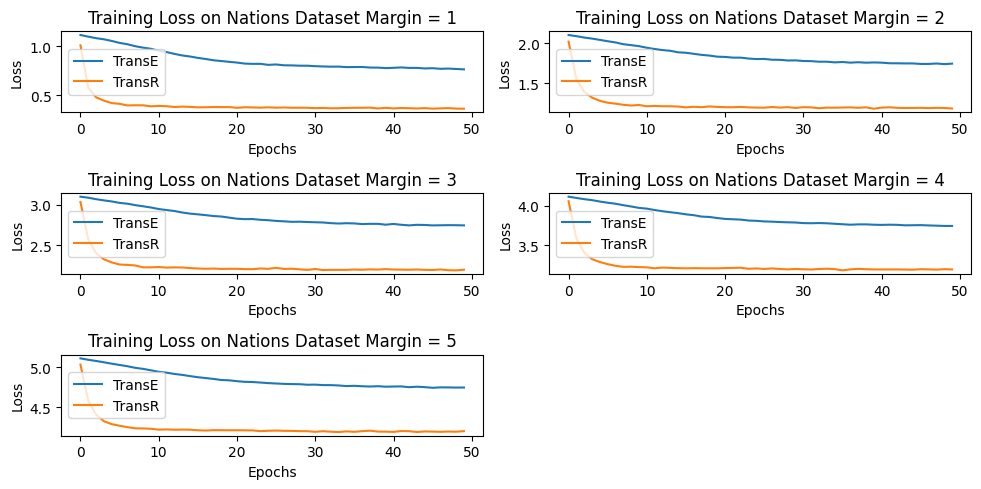

In [13]:
#### Plotting Training Losses #####
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows = 3, ncols = 2,figsize = (10, 5))

ax[0,0].plot(transE_models["Nations"][1]["loss"], label = "TransE")
ax[0,0].plot(transR_models["Nations"][1]["loss"], label = "TransR")
ax[0,0].set_title("Training Loss on Nations Dataset Margin = 1")
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("Loss")
ax[0,0].legend()

ax[0,1].plot(transE_models["Nations"][2]["loss"], label = "TransE")
ax[0,1].plot(transR_models["Nations"][2]["loss"], label = "TransR")
ax[0,1].set_title("Training Loss on Nations Dataset Margin = 2")
ax[0,1].set_xlabel("Epochs")
ax[0,1].set_ylabel("Loss")
ax[0,1].legend()

ax[1,0].plot(transE_models["Nations"][3]["loss"], label = "TransE")
ax[1,0].plot(transR_models["Nations"][3]["loss"], label = "TransR")
ax[1,0].set_title("Training Loss on Nations Dataset Margin = 3")
ax[1,0].set_xlabel("Epochs")
ax[1,0].set_ylabel("Loss")
ax[1,0].legend()

ax[1,1].plot(transE_models["Nations"][4]["loss"], label = "TransE")
ax[1,1].plot(transR_models["Nations"][4]["loss"], label = "TransR")
ax[1,1].set_title("Training Loss on Nations Dataset Margin = 4")
ax[1,1].set_xlabel("Epochs")
ax[1,1].set_ylabel("Loss")
ax[1,1].legend()

ax[2,0].plot(transE_models["Nations"][5]["loss"], label = "TransE")
ax[2,0].plot(transR_models["Nations"][5]["loss"], label = "TransR")
ax[2,0].set_title("Training Loss on Nations Dataset Margin = 5")
ax[2,0].set_xlabel("Epochs")
ax[2,0].set_ylabel("Loss")
ax[2,0].legend()

fig.delaxes(ax[2,1])

plt.tight_layout()

plt.show()

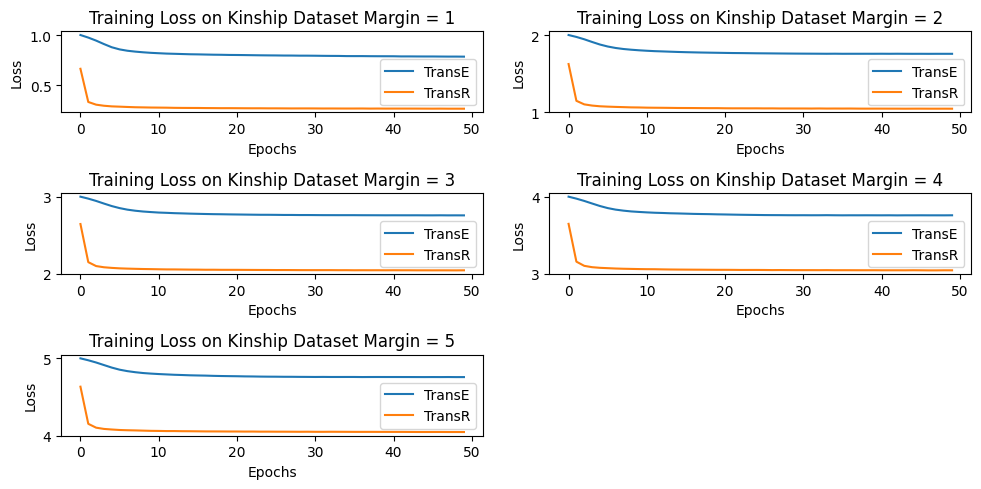

In [14]:
#### Plotting Training Losses #####
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows = 3, ncols = 2,figsize = (10, 5))

ax[0,0].plot(transE_models["Kinship"][1]["loss"], label = "TransE")
ax[0,0].plot(transR_models["Kinship"][1]["loss"], label = "TransR")
ax[0,0].set_title("Training Loss on Kinship Dataset Margin = 1")
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("Loss")
ax[0,0].legend()

ax[0,1].plot(transE_models["Kinship"][2]["loss"], label = "TransE")
ax[0,1].plot(transR_models["Kinship"][2]["loss"], label = "TransR")
ax[0,1].set_title("Training Loss on Kinship Dataset Margin = 2")
ax[0,1].set_xlabel("Epochs")
ax[0,1].set_ylabel("Loss")
ax[0,1].legend()

ax[1,0].plot(transE_models["Kinship"][3]["loss"], label = "TransE")
ax[1,0].plot(transR_models["Kinship"][3]["loss"], label = "TransR")
ax[1,0].set_title("Training Loss on Kinship Dataset Margin = 3")
ax[1,0].set_xlabel("Epochs")
ax[1,0].set_ylabel("Loss")
ax[1,0].legend()

ax[1,1].plot(transE_models["Kinship"][4]["loss"], label = "TransE")
ax[1,1].plot(transR_models["Kinship"][4]["loss"], label = "TransR")
ax[1,1].set_title("Training Loss on Kinship Dataset Margin = 4")
ax[1,1].set_xlabel("Epochs")
ax[1,1].set_ylabel("Loss")
ax[1,1].legend()

ax[2,0].plot(transE_models["Kinship"][5]["loss"], label = "TransE")
ax[2,0].plot(transR_models["Kinship"][5]["loss"], label = "TransR")
ax[2,0].set_title("Training Loss on Kinship Dataset Margin = 5")
ax[2,0].set_xlabel("Epochs")
ax[2,0].set_ylabel("Loss")
ax[2,0].legend()

fig.delaxes(ax[2,1])

plt.tight_layout()

plt.show()

In [15]:
#### Evaluations on the Nations test set ####
margins = [1, 2, 3, 4, 5]

print(f"------------- Evaluation on Nations Test Set -------------")
print(f"------------- TransE Models -------------- ")

for margin in margins:

  print(f"Margin = {margin}")
  model = TransE(num_entities=num_entities, num_relations= num_relations, embedding_dim= 100, margin = margin, norm = 2)
  evaluator = RankBasedEvaluator(history=transE_models, model = model, test_triples = nations_testdata, num_entities = num_entities, num_relations = num_relations,
                                 margin = margin, dataset = "Nations", device = device)

  evaluator()

print(f"------------- TransR Models -------------- ")

for margin in margins:

  print(f"Margin = {margin}")
  model = TransR(num_entities=num_entities, num_relations= num_relations, embedding_dim= 100, margin = margin, norm = 2)
  evaluator = RankBasedEvaluator(history=transR_models, model = model, test_triples = nations_testdata, num_entities = num_entities, num_relations = num_relations,
                                 margin = margin, dataset = "Nations", device = device)
  evaluator()




------------- Evaluation on Nations Test Set -------------
------------- TransE Models -------------- 
Margin = 1
Mean Rank for margin 1 = 6.129353046417236
Hits@10 for margin 1 = 0.8283582089552238
Margin = 2
Mean Rank for margin 2 = 6.034825801849365
Hits@10 for margin 2 = 0.8557213930348259
Margin = 3
Mean Rank for margin 3 = 6.405472755432129
Hits@10 for margin 3 = 0.7835820895522388
Margin = 4
Mean Rank for margin 4 = 6.425373077392578
Hits@10 for margin 4 = 0.8084577114427861
Margin = 5
Mean Rank for margin 5 = 6.313432693481445
Hits@10 for margin 5 = 0.8159203980099502
------------- TransR Models -------------- 
Margin = 1
Mean Rank for margin 1 = 6.5472636222839355
Hits@10 for margin 1 = 0.7835820895522388
Margin = 2
Mean Rank for margin 2 = 6.141790866851807
Hits@10 for margin 2 = 0.8208955223880597
Margin = 3
Mean Rank for margin 3 = 6.248756408691406
Hits@10 for margin 3 = 0.835820895522388
Margin = 4
Mean Rank for margin 4 = 6.363183975219727
Hits@10 for margin 4 = 0.820895

In [16]:
#### Evaluations on the Kinships test set ####
margins = [1,2,3,4,5]

print(f"------------- Evaluation on Kinships Test Set -------------")
print(f"------------- TransE Models -------------- ")

for margin in margins:

  print(f"Margin = {margin}")
  model = TransE(num_entities=knum_entities, num_relations= knum_relations, embedding_dim= 100, margin = margin, norm = 2)
  evaluator = RankBasedEvaluator(history=transE_models, model = model, test_triples = kinship_testdata, num_entities = knum_entities, num_relations = knum_relations,
                                 margin = margin, dataset = "Kinship", device = device)

  evaluator()

print()
print(f"------------- TransR Models -------------- ")

for margin in margins:

  print(f"Margin = {margin}")
  model = TransR(num_entities=knum_entities, num_relations= knum_relations, embedding_dim= 100, margin = margin, norm = 2)
  evaluator = RankBasedEvaluator(history=transR_models, model = model, test_triples = kinship_testdata, num_entities = knum_entities, num_relations = knum_relations,
                                 margin = margin, dataset = "Kinship", device = device)
  evaluator()




------------- Evaluation on Kinships Test Set -------------
------------- TransE Models -------------- 
Margin = 1
Mean Rank for margin 1 = 50.53351974487305
Hits@10 for margin 1 = 0.0935754189944134
Margin = 2
Mean Rank for margin 2 = 50.53584671020508
Hits@10 for margin 2 = 0.10661080074487896
Margin = 3
Mean Rank for margin 3 = 48.65875244140625
Hits@10 for margin 3 = 0.12243947858472998
Margin = 4
Mean Rank for margin 4 = 49.38221740722656
Hits@10 for margin 4 = 0.10800744878957169
Margin = 5
Mean Rank for margin 5 = 49.38407897949219
Hits@10 for margin 5 = 0.12150837988826815

------------- TransR Models -------------- 
Margin = 1
Mean Rank for margin 1 = 49.99906921386719
Hits@10 for margin 1 = 0.10148975791433892
Margin = 2
Mean Rank for margin 2 = 50.36359405517578
Hits@10 for margin 2 = 0.11266294227188083
Margin = 3
Mean Rank for margin 3 = 50.3351936340332
Hits@10 for margin 3 = 0.10567970204841713
Margin = 4
Mean Rank for margin 4 = 50.864990234375
Hits@10 for margin 4 = 0.

### Part 2 :  Similarity ###

For this part we saw that for `Nations` dataset, for `TransE` best margin was `2` and for `TransR` best margin was `3`. So we would use these margins for our next part of the assignment.

In [25]:
def transform(triples, entity_dict, relation_dict):
    validation_ids = []
    for triple in triples:
        tri_id = []
        head = entity_dict[triple[0]]
        relation = relation_dict[triple[1]]
        tail = entity_dict[triple[2]]

        tri_id.append(head)
        tri_id.append(relation)
        tri_id.append(tail)

        validation_ids.append(tri_id)

    return validation_ids


In [26]:
dataset = Nations()
train_triples = dataset.training.mapped_triples.tolist()
test_triples = dataset.testing.mapped_triples.tolist()
num_entities = dataset.num_entities
num_relations = dataset.num_relations

train_triples = bernoulli_negative_sample(train_triples, num_entities)

validation_triples = [
    ['brazil', 'commonbloc1', 'india'],
    ['burma', 'intergovorgs3', 'indonesia'],
    ['china', 'accusation', 'uk'],
    ['cuba', 'reldiplomacy', 'china'],
    ['egypt', 'embassy', 'uk']
]
validation_triples = transform(validation_triples, dataset.entity_to_id, dataset.relation_to_id)
# test_triples = bernoulli_negative_sample(test_triples, num_entities)

train_triples = torch.LongTensor(train_triples)
test_triples = torch.LongTensor(test_triples)
validation_triples = torch.LongTensor(validation_triples)

train_triples = torch.utils.data.TensorDataset(train_triples)
test_triples = torch.utils.data.TensorDataset(test_triples)
validation_triples = torch.utils.data.TensorDataset(validation_triples)

batch_size = 128

nations_traindata = torch.utils.data.DataLoader(train_triples, batch_size=batch_size, shuffle=True)
nations_testdata = torch.utils.data.DataLoader(test_triples, batch_size=batch_size, shuffle=False)
nations_validdata = torch.utils.data.DataLoader(validation_triples, batch_size = batch_size, shuffle = False)

batch_size = 1
nations_eval_traindata = torch.utils.data.DataLoader(train_triples, batch_size=batch_size, shuffle=False)
nations_eval_validdata = torch.utils.data.DataLoader(validation_triples, batch_size = batch_size, shuffle = False)
nations_eval_testdata = torch.utils.data.DataLoader(test_triples, batch_size = batch_size, shuffle = False)

In [27]:
print("------------------- Training TransE Models on Nations Dataset -------------------")
device = "cuda" if torch.cuda.is_available() else "cpu"

similarity_models = {}

model_transe = TransE(num_entities=num_entities, num_relations= num_relations, embedding_dim= 30, margin = 2, norm = 2)
model_transe.to(device)

optimizer = optim.Adam(model_transe.parameters(), lr=0.001)
num_epochs = 50
batch_size = 128

training_history = train_Nations(model_transe, optimizer, nations_traindata, batch_size, num_epochs, device)
similarity_models["transe"] = training_history

print("------------------- Training TransR Models on Nations Dataset -------------------")
model_transr = TransR(num_entities=num_entities, num_relations= num_relations, embedding_dim= 30, margin = 3, norm = 2)
model_transr.to(device)

optimizer2 = optim.Adam(model_transr.parameters(), lr=0.001)
num_epochs = 50
batch_size = 128
training_history = train_Nations(model_transr, optimizer2, nations_traindata, batch_size, num_epochs, device)
similarity_models["transr"] = training_history

------------------- Training TransE Models on Nations Dataset -------------------
------------------- Training TransR Models on Nations Dataset -------------------


In [28]:
import torch.nn.functional as F

class Similarity_matcher:
    def __init__(self, model, validation_triples, train_triples, test_triples, entity_dict, relation_dict, topk = 5):

        self.model = model
        self.device = device
        self.topk = topk

        self.model.to(self.device)

        self.validation_triples = validation_triples
        self.train_triples = train_triples
        self.test_triples = test_triples

        self.entity_dict = {v:k for k,v in entity_dict.items()}
        self.relation_dict = {v:k for k,v in relation_dict.items()}

    def __call__(self):
        self.get_similarity()
        self.get_all_similar()

    def get_all_similar(self):
        for k,v in self.matches.items():
            val_triple = self.inverse_transform(k)
            print(f"For validation triple = {val_triple} -------- top 5 triples in dataset -------")
            for j in v:
                print(f"{self.inverse_transform(j[0])} ------------- similarity score = {j[1].item()}")

            print("-------------------------------------------------------------")

    def inverse_transform(self, triple):
        return [self.entity_dict[triple[0][0].item()], self.relation_dict[triple[0][1].item()], self.entity_dict[triple[0][2].item()]]

    def get_similarity(self):
        self.matches = {}

        self.model.eval()
        with torch.no_grad():
            for batch in tqdm(self.validation_triples):
                val_ = batch[0].to(self.device)
                val_scores = {}
                for batch2 in self.train_triples:

                    tr_ = batch2[0][:,0].to(self.device)

                    val_head, val_rel, val_tail = self.model(val_[:,0], val_[:,1], val_[:,2])
                    tr_head, tr_rel, tr_tail = self.model(tr_[:,0], tr_[:,1], tr_[:,2])

                    val_embed = torch.cat([val_head.squeeze(), val_rel.squeeze(), val_tail.squeeze()])
                    tr_embed = torch.cat([tr_head.squeeze(), tr_rel.squeeze(), tr_tail.squeeze()])


                    val_scores[tr_] =  F.cosine_similarity(val_embed.unsqueeze(dim = 0), tr_embed.unsqueeze(dim = 0))

                if self.test_triples is not None:
                    for batch3 in self.test_triples:

                        tr_ = batch3[0].to(self.device)

                        val_head, val_rel, val_tail = self.model(val_[:,0], val_[:,1], val_[:,2])
                        tr_head, tr_rel, tr_tail = self.model(tr_[:,0], tr_[:,1], tr_[:,2])

                        val_embed = torch.cat([val_head.squeeze(), val_rel.squeeze(), val_tail.squeeze()])
                        tr_embed = torch.cat([tr_head.squeeze(), tr_rel.squeeze(), tr_tail.squeeze()])


                        val_scores[tr_] =  F.cosine_similarity(val_embed.unsqueeze(dim = 0), tr_embed.unsqueeze(dim = 0))

                val_scores = sorted(val_scores.items(), key=lambda x: x[1], reverse=True)
                self.matches[val_] = val_scores[:self.topk]

## Searching Most similar to Validation triples only in Nations Train Set

In [29]:
### Finding the top triples for validation set triples ###
print(f"----------Most similar triples for Validation Data in whole Nations Dataset (Train and Test set)---------")
print(f"Using TransE Model with embedding_dim = 30")

sim_matcher = Similarity_matcher(model = model_transe, validation_triples = nations_eval_validdata,
                                train_triples=nations_eval_traindata, test_triples = None, entity_dict = dataset.entity_to_id, relation_dict =  dataset.relation_to_id)
sim_matcher()

----------Most similar triples for Validation Data in whole Nations Dataset (Train and Test set)---------
Using TransE Model with embedding_dim = 30


100%|██████████| 5/5 [00:08<00:00,  1.73s/it]

For validation triple = ['brazil', 'commonbloc1', 'india'] -------- top 5 triples in dataset -------
['netherlands', 'commonbloc1', 'india'] ------------- similarity score = 0.9853719472885132
['uk', 'commonbloc1', 'india'] ------------- similarity score = 0.9770238399505615
['india', 'commonbloc1', 'netherlands'] ------------- similarity score = 0.9745757579803467
['india', 'commonbloc1', 'uk'] ------------- similarity score = 0.9708834290504456
['india', 'commonbloc1', 'usa'] ------------- similarity score = 0.9687886834144592
-------------------------------------------------------------
For validation triple = ['burma', 'intergovorgs3', 'indonesia'] -------- top 5 triples in dataset -------
['burma', 'relngo', 'indonesia'] ------------- similarity score = 0.9181936979293823
['burma', 'exports3', 'indonesia'] ------------- similarity score = 0.8374428153038025
['burma', 'relngo', 'cuba'] ------------- similarity score = 0.8136572241783142
['burma', 'intergovorgs3', 'usa'] -----------

In [30]:
### Finding the top triples for validation set triples ###
print(f"----------Most similar triples for Validation Data in whole Nations Dataset (Train and Test set)---------")
print(f"Using TransR Model with embedding_dim = 30")

sim_matcher = Similarity_matcher(model = model_transr, validation_triples = nations_eval_validdata,
                                train_triples=nations_eval_traindata, test_triples = None, entity_dict = dataset.entity_to_id, relation_dict =  dataset.relation_to_id)
sim_matcher()

----------Most similar triples for Validation Data in whole Nations Dataset (Train and Test set)---------
Using TransR Model with embedding_dim = 30


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]

For validation triple = ['brazil', 'commonbloc1', 'india'] -------- top 5 triples in dataset -------
['jordan', 'commonbloc1', 'netherlands'] ------------- similarity score = 0.9285945296287537
['brazil', 'commonbloc1', 'jordan'] ------------- similarity score = 0.8209508657455444
['india', 'commonbloc1', 'netherlands'] ------------- similarity score = 0.8159899711608887
['jordan', 'commonbloc1', 'uk'] ------------- similarity score = 0.8070959448814392
['netherlands', 'commonbloc1', 'india'] ------------- similarity score = 0.8058505654335022
-------------------------------------------------------------
For validation triple = ['burma', 'intergovorgs3', 'indonesia'] -------- top 5 triples in dataset -------
['burma', 'intergovorgs3', 'egypt'] ------------- similarity score = 0.9997460842132568
['cuba', 'intergovorgs3', 'egypt'] ------------- similarity score = 0.9444657564163208
['indonesia', 'intergovorgs3', 'egypt'] ------------- similarity score = 0.941648542881012
['poland', 'inte

## Searching Most similar to Validation triples only in Nations Train Set and Test Set

In [31]:
### Finding the top triples for validation set triples ###
print(f"----------Most similar triples for Validation Data in whole Nations Dataset (Train and Test set)---------")
print(f"Using TransE Model with embedding_dim = 30")

sim_matcher = Similarity_matcher(model = model_transe, validation_triples = nations_eval_validdata,
                                train_triples=nations_eval_traindata, test_triples = nations_eval_testdata, entity_dict = dataset.entity_to_id, relation_dict =  dataset.relation_to_id)
sim_matcher()

----------Most similar triples for Validation Data in whole Nations Dataset (Train and Test set)---------
Using TransE Model with embedding_dim = 30


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]

For validation triple = ['brazil', 'commonbloc1', 'india'] -------- top 5 triples in dataset -------
['brazil', 'commonbloc1', 'india'] ------------- similarity score = 1.0000001192092896
['netherlands', 'commonbloc1', 'india'] ------------- similarity score = 0.9853719472885132
['uk', 'commonbloc1', 'india'] ------------- similarity score = 0.9770238399505615
['india', 'commonbloc1', 'netherlands'] ------------- similarity score = 0.9745757579803467
['india', 'commonbloc1', 'uk'] ------------- similarity score = 0.9708834290504456
-------------------------------------------------------------
For validation triple = ['burma', 'intergovorgs3', 'indonesia'] -------- top 5 triples in dataset -------
['burma', 'intergovorgs3', 'indonesia'] ------------- similarity score = 1.0
['burma', 'relngo', 'indonesia'] ------------- similarity score = 0.9181936979293823
['burma', 'exports3', 'indonesia'] ------------- similarity score = 0.8374428153038025
['burma', 'relngo', 'cuba'] ------------- sim

In [32]:
### Finding the top triples for validation set triples ###
print(f"----------Most similar triples for Validation Data in whole Nations Dataset (Train and Test set)---------")
print(f"Using TransR Model with embedding_dim = 30")

sim_matcher = Similarity_matcher(model = model_transr, validation_triples = nations_eval_validdata,
                                train_triples=nations_eval_traindata, test_triples = nations_eval_testdata, entity_dict = dataset.entity_to_id, relation_dict =  dataset.relation_to_id)
sim_matcher()

----------Most similar triples for Validation Data in whole Nations Dataset (Train and Test set)---------
Using TransR Model with embedding_dim = 30


100%|██████████| 5/5 [00:13<00:00,  2.69s/it]

For validation triple = ['brazil', 'commonbloc1', 'india'] -------- top 5 triples in dataset -------
['brazil', 'commonbloc1', 'india'] ------------- similarity score = 1.0
['jordan', 'commonbloc1', 'netherlands'] ------------- similarity score = 0.9285945296287537
['brazil', 'commonbloc1', 'jordan'] ------------- similarity score = 0.8209508657455444
['india', 'commonbloc1', 'netherlands'] ------------- similarity score = 0.8159899711608887
['jordan', 'commonbloc1', 'uk'] ------------- similarity score = 0.8070959448814392
-------------------------------------------------------------
For validation triple = ['burma', 'intergovorgs3', 'indonesia'] -------- top 5 triples in dataset -------
['burma', 'intergovorgs3', 'indonesia'] ------------- similarity score = 1.0
['burma', 'intergovorgs3', 'egypt'] ------------- similarity score = 0.9997460842132568
['cuba', 'intergovorgs3', 'egypt'] ------------- similarity score = 0.9444657564163208
['indonesia', 'intergovorgs3', 'egypt'] ----------